In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import torch.nn.functional as F

feature_cols = [
    "year",
    "membership_year",
    "is_household",
    "vehicle_count",
    "vehicle_age_mean",
    "beløp",
    "gave_feedback",
    "mean_feedback",
    "age",
    "gender",
    "sentralitetsindex",
]

train_examples = torch.load("all/train_examples.pt")
val_examples = torch.load("all/val_examples.pt")


def collate_fn(batch):
    seqs, lengths, labels = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True)  # [B, T, F]
    lengths = torch.tensor(lengths, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    max_len = seqs_padded.size(1)
    attn_mask = (
        torch.arange(max_len, device=lengths.device)
        .unsqueeze(0)
        .expand(len(lengths), -1)
    )
    attn_mask = attn_mask >= lengths.unsqueeze(1)  # True at padding positions

    return seqs_padded, lengths, attn_mask, labels


class ChurnDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]


class LearnablePositionalEncoding(nn.Module):
    """A simple learnable absolute positional embedding."""

    def __init__(self, max_len: int, dim: int):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(max_len, dim) * 0.02)

    def forward(self, x: torch.Tensor):  # x: [B, T, D]
        return x + self.pe[: x.size(1)]


class TitansMemory(nn.Module):
    """Lightweight key-value memory MLP (now trained end-to-end)."""

    def __init__(self, dim: int, hidden_dim: int = 128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, keys):  # [B, T, D]
        return self.mlp(keys)


class Titans(nn.Module):
    def __init__(
        self,
        input_size: int,
        d_model: int = 64,
        num_classes: int = 3,
        persistent_tokens: int = 1,
        aux_alpha: float = 0.1,  # weight for auxiliary memory loss
        max_seq_len: int = 365,  # adjust to data
    ):
        super().__init__()
        self.d_model = d_model
        self.persistent_tokens = persistent_tokens
        self.aux_alpha = aux_alpha

        # Embedding & positional enc.
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = LearnablePositionalEncoding(
            max_seq_len + persistent_tokens, d_model
        )

        # CLS / persistent tokens
        self.persistent = nn.Parameter(torch.randn(persistent_tokens, d_model) * 0.02)

        # Memory-gated branch
        self.to_key = nn.Linear(d_model, d_model)
        self.to_value = nn.Linear(d_model, d_model)
        self.memory = TitansMemory(d_model)
        self.gate_layer = nn.Linear(d_model, d_model)

        # Add a small Transformer encoder after memory interaction
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=4,
            dim_feedforward=256,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=1)

        self.classifier = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, seqs, lengths, attn_mask):
        """Return logits and (optionally) auxiliary memory loss."""
        B, T, _ = seqs.shape
        x = self.input_proj(seqs)  # [B, T, D]
        x = self.dropout(x)

        # prepend persistent CLS token(s)
        cls_token = self.persistent.unsqueeze(0).expand(B, -1, -1)  # [B, P, D]
        x = torch.cat([cls_token, x], dim=1)  # [B, P+T, D]

        # update padding mask (False = keep, True = pad)
        # build src_key_padding_mask: prepend *False* for the persistent/CLS positions
        new_mask = torch.cat(
            [
                torch.zeros(
                    B, self.persistent_tokens, dtype=torch.bool, device=attn_mask.device
                ),
                attn_mask,
            ],
            dim=1,
        )

        # positional encoding
        x = self.pos_enc(x)

        # memory interaction (no detach)
        keys = self.to_key(x)
        values_target = self.to_value(x)
        mem_out = self.memory(keys)  # [B, P+T, D]
        gate = torch.sigmoid(self.gate_layer(x))
        x = x + gate * mem_out

        # (optional) auxiliary reconstruction loss
        aux_loss = (
            F.mse_loss(mem_out, values_target, reduction="mean")
            if self.training
            else 0.0
        )

        # transformer encoder (can attend to CLS + positions)
        x = self.encoder(x, src_key_padding_mask=new_mask)

        # use CLS representation
        cls_repr = x[:, 0]
        logits = self.classifier(cls_repr)
        return logits, aux_loss


def run_epoch(model, loader, criterion, optimiser=None):
    is_train = optimiser is not None
    model.train() if is_train else model.eval()

    running_loss, running_acc, total = 0.0, 0.0, 0
    loop = tqdm(loader, desc="Train" if is_train else "Val", leave=False)

    for seqs, lengths, attn_mask, labels in loop:
        seqs, lengths, attn_mask, labels = (
            seqs.to(device),
            lengths.to(device),
            attn_mask.to(device),
            labels.to(device),
        )

        logits, aux_loss = model(seqs, lengths, attn_mask)
        ce_loss = criterion(logits, labels)
        loss = ce_loss + model.aux_alpha * aux_loss

        if is_train:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        preds = logits.argmax(dim=1)
        running_loss += loss.item() * labels.size(0)
        running_acc += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss / total, acc=running_acc / total)

    return running_loss / total, running_acc / total


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = ChurnDataset(train_examples)
val_ds = ChurnDataset(val_examples)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)


all_lengths = [length for _, length, _ in train_examples + val_examples]
max_seq_len = max(all_lengths)
model = Titans(input_size=len(feature_cols), max_seq_len=max_seq_len).to(device)
criterion = nn.CrossEntropyLoss()

optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

import wandb

wandb.init(project="churn", name="Titans")
n_epochs = 200
best_val = 0.0

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimiser)
    val_loss, val_acc = run_epoch(model, val_loader, criterion, optimiser=None)

    print(
        f"Epoch {epoch:02d} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
        f"| val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
    )
    wandb.log(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        }
    )

ROC AUC Score (OvR): 0.7433
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.71      0.58     21127
           1       0.69      0.58      0.63     34706
           2       0.44      0.35      0.39     19394

    accuracy                           0.56     75227
   macro avg       0.54      0.55      0.53     75227
weighted avg       0.57      0.56      0.55     75227



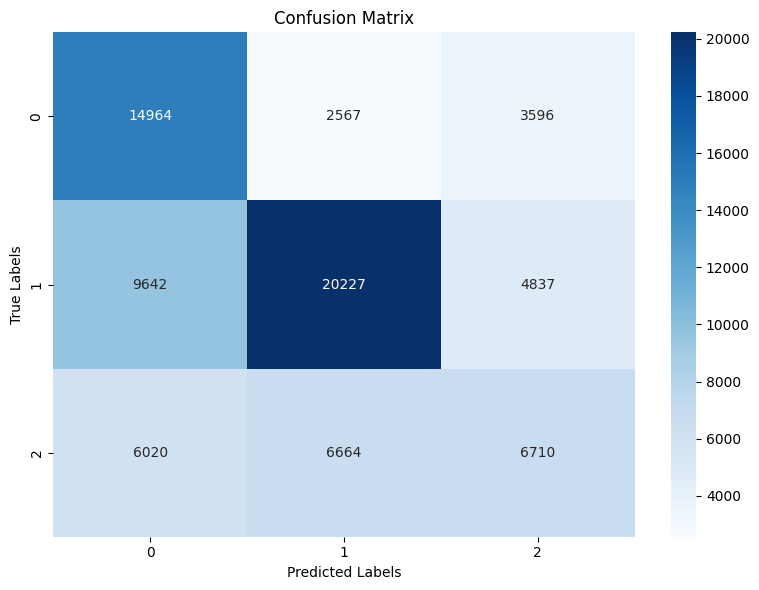

In [4]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Containers for labels and predictions
all_labels = []
all_preds = []
all_probs = []

# Collect predictions
with torch.no_grad():
    for seqs, lengths, attn_mask, labels in tqdm(
        val_loader, desc="Collecting predictions"
    ):
        seqs, lengths, attn_mask, labels = (
            seqs.to(device),
            lengths.to(device),
            attn_mask.to(device),
            labels.to(device),
        )

        logits, _ = model(seqs, lengths, attn_mask)  # Unpack tuple correctly
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

# Concatenate results
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

# ROC AUC Score (one-vs-rest)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

# Classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:\n", report)

# Confusion matrix heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()